In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
import fnmatch
import csv
import pickle
import warnings
import torch
import time
import seaborn as sns
sns.set()

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Create architecture

In [2]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.sigmoid)
    #hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.15)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


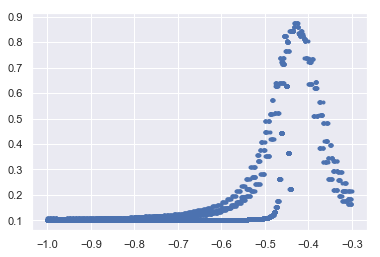

In [37]:
tf.reset_default_graph()
from copy import copy
from sklearn.model_selection import train_test_split

x = tf.placeholder("float", [None, 3], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_train_full_1 = pd.read_csv('Data/Apr/training_merged_3.csv', header=0)
df_train_full_1.drop_duplicates(subset=None, inplace=True)
df_train_pseudo = pd.read_csv('Data/May/pseudo_trainingsdata_x.csv', header=0, names=['x', 'time', 'energy', 'y', 'sigma'])
df_train_full = pd.concat([df_train_full_1, df_train_pseudo], axis=0, ignore_index=True)


## Select only the data with a minimum intensity value 
intensity_min = .2
energyloss_max = -0.3
df_train_full = df_train_full[df_train_full['x'] < energyloss_max]

## Find the value where intensity of the 10 ms, 200kev is 20%. This is 0.440306

indexNames = df_train_full[ (df_train_full['time'] == .1) & (df_train_full['energy'] ==2)& (df_train_full['x'] > -0.44) ].index
df_train_full.drop(indexNames, inplace=True)

#df_train_full.drop((df_train_full['time'] == .1) & (df_train_full['energy'] == 2))
#df_train_full_bla = df_train_full[df_train_full['time'] == .1]
#df_train_full_bla = df_train_full_bla[df_train_full_bla['energy'] == 2]
#df_train_full_bla = df_train_full_bla[df_train_full_bla['y'] > .2]

#df_train_full_bla = df_train_full[(df_train_full['time'] == .1) & (df_train_full['energy'] == 2)]
#print(df_train_full_bla)

#print(df_train_full[(df_train_full['time']==.1) & (df_train_full['energy']==2)])

df_train, df_test = train_test_split(df_train_full, test_size=0.3)
train_x = np.array(df_train[['x', 'time', 'energy']].to_numpy())
N_train = len(train_x[:,0])
train_y = np.copy(df_train['y']).reshape(N_train,1)
train_sigma = np.copy(df_train['sigma']).reshape(N_train,1)

test_x = np.array(df_test[['x', 'time', 'energy']].to_numpy())
N_test = len(test_x[:,0])
test_y = np.copy(df_test['y']).reshape(N_test,1)
test_sigma = np.copy(df_test['sigma']).reshape(N_test,1)

predictions = make_model(x,1)

plt.plot(df_train_full['x'],df_train_full['y'],'.')


## Set a restriction for the minimum relative error

In [22]:
relative_error = np.divide(train_sigma, train_y)
treshold = 0.0001
treshold_error_index = np.where(relative_error >= treshold)[0]
train_x, train_y, train_sigma = train_x[treshold_error_index], train_y[treshold_error_index], train_sigma[treshold_error_index]
N_train = len(train_x)

relative_error = np.divide(test_sigma, test_y)
treshold_error_index = np.where(relative_error > treshold)[0]
test_x, test_y, test_sigma = test_x[treshold_error_index], test_y[treshold_error_index], test_sigma[treshold_error_index]
N_test = len(test_x)


## Create MC replicas

In [38]:
### Create array of Nrep training samples
Nrep = 1000
#pbar = tqdm(total=Nrep)
train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
    train_rep = np.random.normal(0, train_sigma)
    test_rep = np.random.normal(0, test_sigma)
    train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
    test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
    i+=1 
train_y_reps[train_y_reps < .1] = .1    
test_y_reps[test_y_reps < .1] = .1
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

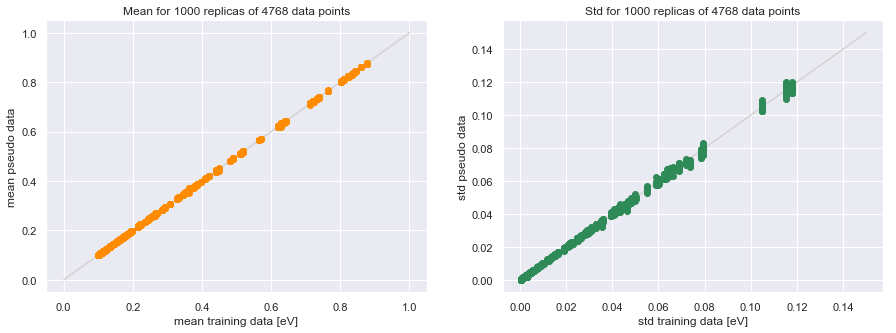

In [39]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Mean for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(train_y, mean_reps, 'o', color = 'darkorange', label = 'Predictions pseudodata')
plt.grid(True)
plt.xlabel(r'mean training data [eV]')
plt.ylabel(r'mean pseudo data')

plt.subplot(122)
plt.grid(True)
plt.title('Std for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,0.15,10), np.linspace(0,0.15,10), color='lightgrey')
plt.plot(train_sigma, std_reps, 'o', color='seagreen', label = 'Predictions pseudodata')
plt.xlabel(r'std training data [eV]')
plt.ylabel(r'std pseudo data')

plt.show()

In [34]:
## Beam energy interpolation

import random
N_pred = 4000
part1 = 1000
interpol_energy1 = .6 #*100 keV
interpol_energy2 = 2 #*100 keV
interpol_energy3 = .4
interpol_energy4 = 2.2
interpol_time = .1

predict_x = np.zeros(shape=(N_pred, 3))
predict_x[:part1,0] = np.linspace(-1,1,part1)
predict_x[part1:2*part1, 0] = np.linspace(-1,1,part1)
predict_x[2*part1:3*part1, 0] = np.linspace(-1,1,part1)
predict_x[3*part1:, 0] = np.linspace(-1,1,part1)
predict_x[:,1] = interpol_time * np.ones(N_pred)
predict_x[:part1,2] = interpol_energy1 * np.ones(part1)
predict_x[part1:2*part1,2] = interpol_energy2 * np.ones(part1)
predict_x[2*part1:3*part1,2] = interpol_energy3 * np.ones(part1)
predict_x[3*part1:,2] = interpol_energy4 * np.ones(part1)

predict_x2 = copy(predict_x)
predict_x2[:,1] = 1 * np.ones(N_pred)
predict_x = np.vstack([predict_x, predict_x2])

In [35]:
import time
from datetime import datetime

training_epochs = 60000
max_rising_epochs = 10000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000
chi_array = []

tic = time.time()

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
eta = 3e-2
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(cost)
saver = tf.train.Saver(max_to_keep=50)

i = 0
Nrep = 20

while i < (Nrep):
    
    """Training data: train_y = D_i + rand.norm(0, sigma_i);
    use train_y = gaus_y + rand.norm(0, sigma_i) in case of Closure testing"""
    
    train_y = train_y_reps[:,i].reshape(N_train,1)
    test_y = test_y_reps[:,i].reshape(N_test,1)

    ### Train and validate
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    # Create a saver.

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            
            
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})
            

            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)
                saver.save(sess, 'Models/my-model.ckpt', global_step=epoch , write_meta_graph=False) 
                

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)
                saver.save(sess, 'Models/my-model.ckpt', global_step=epoch , write_meta_graph=False) 
                break
        
            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch
                
        best_iteration = np.argmin(array_test) 
        best_epoch = best_iteration * display_step
        best_model = 'Models/my-model.ckpt-%(s)s' % {'s': best_epoch}
        
        print("Optimization Finished! Best model after epoch %(s)s" % {'s': best_epoch})
        
        
        #saver = tf.train.import_meta_graph('my-model-8000.meta')
        saver.restore(sess, best_model)
        
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            }) 
        
        
        extrapolation = sess.run(predictions,
                            feed_dict={
                                x: predict_x
                            })
    
    sess.close()

    # save to csv file
    predictions_values = predictions_values.reshape(N_train,)
    toc = time.time()
    print("Elapsed time:", toc-tic)
    
    now = datetime.now()
  
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    d_string = now.strftime("%d.%m.%Y")
    t_string = now.strftime("%H:%M:%S")

    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    g = np.array(train_x[:,1])
    h = np.array(train_x[:,2])
    k1 = np.array(predict_x[:,0])
    k2 = np.array(predict_x[:,1])
    k3 = np.array(predict_x[:,2])
    l = np.array(extrapolation)
    
    chi_array.append(d[-1])

    best_chi = np.where(array_test == min(array_test))
    np.savetxt('Data/Results/%(date)s/xyp1p2_all_e%(epoch)s_round1_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(a,b,c,g,h)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
    np.savetxt('Data/Results/%(date)s/chi_all_e%(epoch)s_round1_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(d,e)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
    np.savetxt('Data/Results/%(date)s/extrapolation_e%(epoch)s_round1_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(k1, k2, k3, l)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
 
    print(i)
    i+=1

Start training on 4768 and validating on 2044 samples
Epoch: 0001 | Training cost= 1337959.750000000 | Validation cost= 457149.937500000
Epoch: 1001 | Training cost= 35.230415344 | Validation cost= 31.359443665
Epoch: 2001 | Training cost= 33.736694336 | Validation cost= 30.000856400
Epoch: 3001 | Training cost= 32.689838409 | Validation cost= 29.108205795
Epoch: 4001 | Training cost= 31.959154129 | Validation cost= 28.470664978
Epoch: 5001 | Training cost= 30.325313568 | Validation cost= 26.868110657
Epoch: 6001 | Training cost= 237.834777832 | Validation cost= 59.887588501
Epoch: 7001 | Training cost= 26.054162979 | Validation cost= 22.442356110
Epoch: 8001 | Training cost= 25.526645660 | Validation cost= 21.798007965
Epoch: 9001 | Training cost= 25.358936310 | Validation cost= 21.633024216
Epoch: 10001 | Training cost= 25.033535004 | Validation cost= 21.271507263
Epoch: 11001 | Training cost= 24.799188614 | Validation cost= 21.076606750
Epoch: 12001 | Training cost= 24.370889664 | V

Epoch: 39001 | Training cost= 1.248710632 | Validation cost= 1.345714331
Epoch: 40001 | Training cost= 37.027984619 | Validation cost= 35.904392242
Epoch: 41001 | Training cost= 1.240954280 | Validation cost= 1.341596723
Epoch: 42001 | Training cost= 40.606990814 | Validation cost= 31.275102615
Epoch: 43001 | Training cost= 1.232284188 | Validation cost= 1.335234761
Epoch: 44001 | Training cost= 1.505916476 | Validation cost= 1.352086306
Epoch: 45001 | Training cost= 1.221641541 | Validation cost= 1.325080156
Epoch: 46001 | Training cost= 1.216409683 | Validation cost= 1.318031073
Epoch: 47001 | Training cost= 1.210561991 | Validation cost= 1.311533809
Epoch: 48001 | Training cost= 1.205797076 | Validation cost= 1.304337740
Epoch: 49001 | Training cost= 1.202861190 | Validation cost= 1.298940659
Epoch: 50001 | Training cost= 1.196396589 | Validation cost= 1.292852044
Epoch: 51001 | Training cost= 1.192358136 | Validation cost= 1.287724257
Epoch: 52001 | Training cost= 1.255085826 | Val

Epoch: 25001 | Training cost= 1.758226275 | Validation cost= 2.069296837
Epoch: 26001 | Training cost= 1.709693432 | Validation cost= 1.996562958
Epoch: 27001 | Training cost= 1.678759694 | Validation cost= 1.960303068
Epoch: 28001 | Training cost= 1.656087637 | Validation cost= 1.934251904
Epoch: 29001 | Training cost= 1.841569901 | Validation cost= 2.227958441
Epoch: 30001 | Training cost= 1.627113342 | Validation cost= 1.904708624
Epoch: 31001 | Training cost= 1.600178599 | Validation cost= 1.878448844
Epoch: 32001 | Training cost= 1.547191858 | Validation cost= 1.826565146
Epoch: 33001 | Training cost= 1.432436347 | Validation cost= 1.699502230
Epoch: 34001 | Training cost= 1.234877467 | Validation cost= 1.509846807
Epoch: 35001 | Training cost= 1.225406766 | Validation cost= 1.459475398
Epoch: 36001 | Training cost= 1.124703765 | Validation cost= 1.399271011
Epoch: 37001 | Training cost= 1.111812472 | Validation cost= 1.386341214
Epoch: 38001 | Training cost= 1.106064200 | Validat

Epoch: 11001 | Training cost= 13.587823868 | Validation cost= 13.418473244
Epoch: 12001 | Training cost= 12.581320763 | Validation cost= 11.873388290
Epoch: 13001 | Training cost= 12.263657570 | Validation cost= 11.623518944
Epoch: 14001 | Training cost= 11.834394455 | Validation cost= 10.283766747
Epoch: 15001 | Training cost= 3.133246183 | Validation cost= 3.580146074
Epoch: 16001 | Training cost= 2.369952440 | Validation cost= 2.692147493
Epoch: 17001 | Training cost= 2.171048403 | Validation cost= 2.483915329
Epoch: 18001 | Training cost= 2.064210653 | Validation cost= 2.367402792
Epoch: 19001 | Training cost= 2.031980276 | Validation cost= 2.314821005
Epoch: 20001 | Training cost= 1.942307591 | Validation cost= 2.182711601
Epoch: 21001 | Training cost= 2.183714867 | Validation cost= 2.476764917
Epoch: 22001 | Training cost= 1.799183249 | Validation cost= 1.979149699
Epoch: 23001 | Training cost= 1.733058691 | Validation cost= 1.870172858
Epoch: 24001 | Training cost= 1.694104433 |

Optimization Finished! Best model after epoch 57000
INFO:tensorflow:Restoring parameters from Models/my-model.ckpt-57000
Elapsed time: 1178.8893570899963
6
Start training on 4768 and validating on 2044 samples
Epoch: 0001 | Training cost= 2130043.500000000 | Validation cost= 1183994.875000000
Epoch: 1001 | Training cost= 40.375545502 | Validation cost= 35.754524231
Epoch: 2001 | Training cost= 38.049739838 | Validation cost= 33.724922180
Epoch: 3001 | Training cost= 35.886474609 | Validation cost= 31.954065323
Epoch: 4001 | Training cost= 34.468917847 | Validation cost= 30.761007309
Epoch: 5001 | Training cost= 33.449951172 | Validation cost= 29.808755875
Epoch: 6001 | Training cost= 32.026218414 | Validation cost= 28.494480133
Epoch: 7001 | Training cost= 27.943506241 | Validation cost= 24.418899536
Epoch: 8001 | Training cost= 21.785324097 | Validation cost= 18.743808746
Epoch: 9001 | Training cost= 16.594150543 | Validation cost= 14.432153702
Epoch: 10001 | Training cost= 16.2086887

Epoch: 46001 | Training cost= 1.155610561 | Validation cost= 1.207938552
Epoch: 47001 | Training cost= 1.155318856 | Validation cost= 1.207334995
Epoch: 48001 | Training cost= 1.231602669 | Validation cost= 1.260118365
Epoch: 49001 | Training cost= 3.715306520 | Validation cost= 5.267547607
Epoch: 50001 | Training cost= 1.149681449 | Validation cost= 1.206495643
Epoch: 51001 | Training cost= 1.149357677 | Validation cost= 1.205815554
Epoch: 52001 | Training cost= 1.342830420 | Validation cost= 1.206261516
Epoch: 53001 | Training cost= 1.147529721 | Validation cost= 1.205228567
Epoch: 54001 | Training cost= 1.147561550 | Validation cost= 1.204960942
Epoch: 55001 | Training cost= 1.148654103 | Validation cost= 1.224523783
Epoch: 56001 | Training cost= 1.145589948 | Validation cost= 1.203871369
Epoch: 57001 | Training cost= 1.173309565 | Validation cost= 1.229054570
Epoch: 58001 | Training cost= 1.149210930 | Validation cost= 1.215867043
Epoch: 59001 | Training cost= 1.135509372 | Validat

Epoch: 32001 | Training cost= 1.378037453 | Validation cost= 1.300706148
Epoch: 33001 | Training cost= 1.149644971 | Validation cost= 1.287458301
Epoch: 34001 | Training cost= 1.248785615 | Validation cost= 1.313959002
Epoch: 35001 | Training cost= 1.144922614 | Validation cost= 1.280278563
Epoch: 36001 | Training cost= 1.146012306 | Validation cost= 1.280523300
Epoch: 37001 | Training cost= 1.141496062 | Validation cost= 1.275172353
Epoch: 38001 | Training cost= 1.145156503 | Validation cost= 1.285641789
Epoch: 39001 | Training cost= 1.136057138 | Validation cost= 1.267033935
Epoch: 40001 | Training cost= 1.133315682 | Validation cost= 1.261259198
Epoch: 41001 | Training cost= 1.129886270 | Validation cost= 1.256637335
Epoch: 42001 | Training cost= 36.824245453 | Validation cost= 36.004417419
Epoch: 43001 | Training cost= 1.133838415 | Validation cost= 1.256799698
Epoch: 44001 | Training cost= 1.125385642 | Validation cost= 1.250981212
Epoch: 45001 | Training cost= 1.126685858 | Valid

Epoch: 18001 | Training cost= 3.019036531 | Validation cost= 3.459082127
Epoch: 19001 | Training cost= 2.972714424 | Validation cost= 3.419870615
Epoch: 20001 | Training cost= 2.712214231 | Validation cost= 3.081385851
Epoch: 21001 | Training cost= 2.119693518 | Validation cost= 2.409732342
Epoch: 22001 | Training cost= 2.527328730 | Validation cost= 2.500585556
Epoch: 23001 | Training cost= 1.993682861 | Validation cost= 2.226864576
Epoch: 24001 | Training cost= 1.968207002 | Validation cost= 2.191427708
Epoch: 25001 | Training cost= 1.946528673 | Validation cost= 2.164662123
Epoch: 26001 | Training cost= 1.940437078 | Validation cost= 2.143469810
Epoch: 27001 | Training cost= 1.684771895 | Validation cost= 1.790078521
Epoch: 28001 | Training cost= 1.983822823 | Validation cost= 1.906452894
Epoch: 29001 | Training cost= 1.473500371 | Validation cost= 1.613567472
Epoch: 30001 | Training cost= 1.361632943 | Validation cost= 1.728159070
Epoch: 31001 | Training cost= 1.232232571 | Validat

Epoch: 4001 | Training cost= 31.851257324 | Validation cost= 28.264490128
Epoch: 5001 | Training cost= 29.186943054 | Validation cost= 25.785306931
Epoch: 6001 | Training cost= 25.698642731 | Validation cost= 22.283220291
Epoch: 7001 | Training cost= 29.593057632 | Validation cost= 141.808334351
Epoch: 8001 | Training cost= 22.668220520 | Validation cost= 19.470636368
Epoch: 9001 | Training cost= 21.632404327 | Validation cost= 18.587299347
Epoch: 10001 | Training cost= 20.659910202 | Validation cost= 17.783636093
Epoch: 11001 | Training cost= 19.424070358 | Validation cost= 16.787054062
Epoch: 12001 | Training cost= 17.101665497 | Validation cost= 14.958402634
Epoch: 13001 | Training cost= 14.340003967 | Validation cost= 12.830486298
Epoch: 14001 | Training cost= 13.025274277 | Validation cost= 11.911407471
Epoch: 15001 | Training cost= 12.424532890 | Validation cost= 11.491333961
Epoch: 16001 | Training cost= 12.163047791 | Validation cost= 11.279371262
Epoch: 17001 | Training cost= 

Epoch: 53001 | Training cost= 7.102543831 | Validation cost= 3.227188826
Epoch: 54001 | Training cost= 1.101243854 | Validation cost= 1.217912674
Epoch: 55001 | Training cost= 1.094176888 | Validation cost= 1.211196184
Epoch: 56001 | Training cost= 1.096530199 | Validation cost= 1.213415980
Epoch: 57001 | Training cost= 1.295982122 | Validation cost= 1.544454455
Epoch: 58001 | Training cost= 1.092555761 | Validation cost= 1.210371494
Epoch: 59001 | Training cost= 1.375376821 | Validation cost= 2.272798061
Optimization Finished! Best model after epoch 58000
INFO:tensorflow:Restoring parameters from Models/my-model.ckpt-58000
Elapsed time: 2761.6573288440704
15
Start training on 4768 and validating on 2044 samples
Epoch: 0001 | Training cost= 2075259.875000000 | Validation cost= 1053765.500000000
Epoch: 1001 | Training cost= 42.205066681 | Validation cost= 37.756919861
Epoch: 2001 | Training cost= 37.742183685 | Validation cost= 33.829574585
Epoch: 3001 | Training cost= 35.261535645 | Va

Epoch: 39001 | Training cost= 2.551051855 | Validation cost= 3.640066624
Epoch: 40001 | Training cost= 1.134403467 | Validation cost= 1.308272481
Epoch: 41001 | Training cost= 1.138595939 | Validation cost= 1.309643388
Epoch: 42001 | Training cost= 12.516304970 | Validation cost= 17.350440979
Epoch: 43001 | Training cost= 1.130151510 | Validation cost= 1.306295037
Epoch: 44001 | Training cost= 1.129486322 | Validation cost= 1.305944443
Epoch: 45001 | Training cost= 1.130656004 | Validation cost= 1.305143237
Epoch: 46001 | Training cost= 17.668195724 | Validation cost= 13.183301926
Epoch: 47001 | Training cost= 1.127239943 | Validation cost= 1.305177450
Epoch: 48001 | Training cost= 1.126606464 | Validation cost= 1.304953098
Epoch: 49001 | Training cost= 1.539909840 | Validation cost= 1.566734791
Epoch: 50001 | Training cost= 1.123848200 | Validation cost= 1.303389907
Epoch: 51001 | Training cost= 1.121258378 | Validation cost= 1.303493619
Epoch: 52001 | Training cost= 1.120471716 | Val

Epoch: 25001 | Training cost= 2.723526001 | Validation cost= 3.390723705
Epoch: 26001 | Training cost= 2.377778053 | Validation cost= 2.752029896
Epoch: 27001 | Training cost= 2.043873310 | Validation cost= 2.276760578
Epoch: 28001 | Training cost= 10.143862724 | Validation cost= 4.114005089
Epoch: 29001 | Training cost= 1.644309282 | Validation cost= 1.789733648
Epoch: 30001 | Training cost= 9.983493805 | Validation cost= 15.291700363
Epoch: 31001 | Training cost= 2.442424297 | Validation cost= 2.415893793
Epoch: 32001 | Training cost= 1.312463522 | Validation cost= 1.444054484
Epoch: 33001 | Training cost= 1.227123499 | Validation cost= 1.359719038
Epoch: 34001 | Training cost= 1.194071174 | Validation cost= 1.317636490
Epoch: 35001 | Training cost= 1.179407120 | Validation cost= 1.300175309
Epoch: 36001 | Training cost= 1.180371642 | Validation cost= 1.296299934
Epoch: 37001 | Training cost= 1.166657925 | Validation cost= 1.283344030
Epoch: 38001 | Training cost= 1.159812927 | Valid

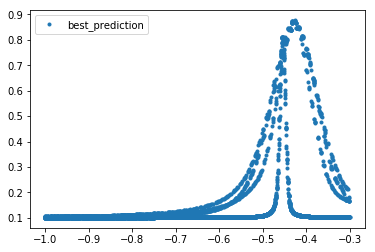

In [107]:
plt.plot(train_x[:,0], predictions_values, '.', label='best_prediction')
#plt.plot(train_x[:,0], (predictions_values_0), '.', label='final')
plt.legend()

### Plot outputs

In [340]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


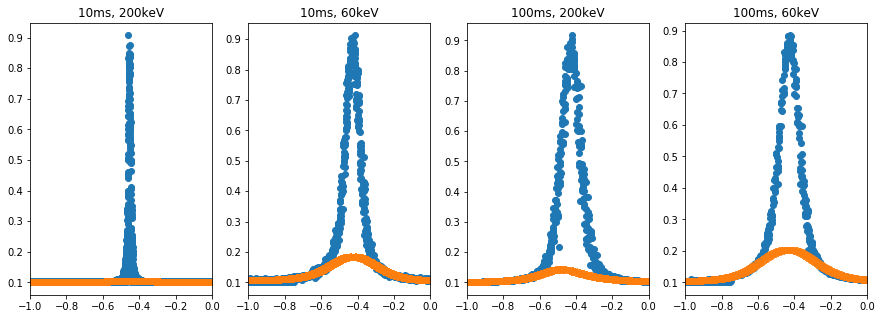

In [16]:
plt.figure(figsize=(15,5))

index10200 = np.where((train_x[:,1] == .1) & (train_x[:,2] == 2))
index1060 = np.where((train_x[:,1] == .1) & (train_x[:,2] == .6))
index100200 = np.where((train_x[:,1] == 1) & (train_x[:,2] == 2))
index10060 = np.where((train_x[:,1] == 1) & (train_x[:,2] == .6))

index10 = np.where(train_x[:,1] == .1)
index100 = np.where(train_x[:,1] == 1)

plt.subplot(141)
plt.title('10ms, 200keV')
plt.xlim([-1,0])
plt.plot(train_x[index10200,0].T, train_y[index10200],'o')
plt.plot(train_x[index10200,0].T, predictions_values[index10200], 'x')
#plt.plot(train_x[index10200,0].T, train_y[index10200],'o')

plt.subplot(142)
plt.xlim([-1,0])
plt.title('10ms, 60keV')
plt.plot(train_x[index1060,0].T, train_y[index1060],'o')
plt.plot(train_x[index1060,0].T, predictions_values[index1060], 'x')

plt.subplot(143)
plt.xlim([-1,0])
plt.title('100ms, 200keV')
plt.plot(train_x[index100200,0].T, train_y[index100200],'o')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x')

plt.subplot(144)
plt.xlim([-1,0])
plt.title('100ms, 60keV')
plt.plot(train_x[index10060,0].T, train_y[index10060],'o')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.show()


Below, the distribution of $\chi^2$ is plotted for training over the $N_{rep}$ MC replicas.

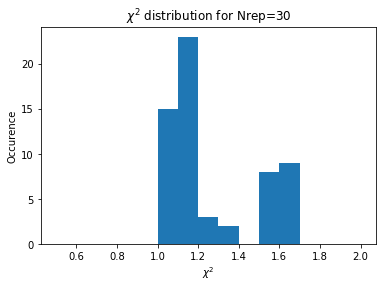

In [162]:
%run Evaluate_pseudodata.ipynb
%run Functions.ipynb
Nrep=30
plt.hist(chi2_array, bins=15, range=[0.5, 2])
plt.title('$\chi^2$ distribution for Nrep=30')
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/%(date)s/aaa chidistribution_%(epoch)s_Nrep=%(i)s' % {"date": d_string, "epoch": training_epochs, "i": Nrep })

plt.show()


## Residuals

In [147]:
N_train = len(train_x[:,0])

best_pred = pseudo_pred[N_train*12 :N_train*13 ]
best_y = pseudo_y[N_train*12 :N_train*13]
train_sigma = train_sigma.reshape(N_train,)

best_res = residuals(best_pred, best_y, train_sigma)

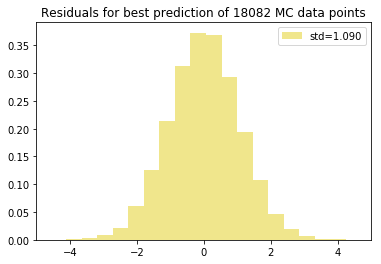

In [148]:
n, bins = np.histogram(best_res, bins=10)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

label1 = 'std=%(std).5s' % {"std":sd}

fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1])

plt.xlim([-5,5])
plt.show()

## Extrapolation in energy loss

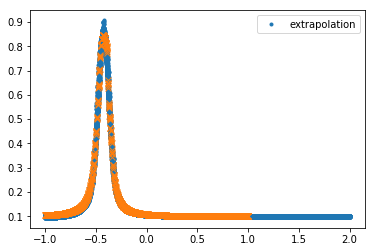

In [224]:
x_extrapol = extrapolation['dE']
prediction = extrapolation['D']
plt.plot(x_extrapol, prediction, '.', label='extrapolation')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.legend()


## Interpolation in Beam Energy

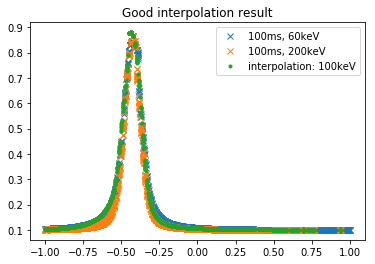

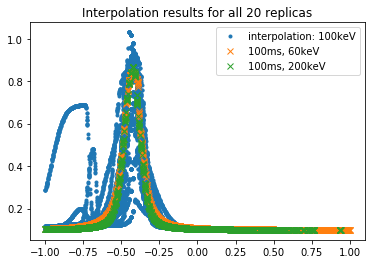

In [230]:
%run Evaluate_pseudodata.ipynb

x_interpol = interpolation['dE']

k=4
prediction_interpol = interpolation['D']
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.plot(x_interpol[k * N_interpol : (k+1)*N_interpol], prediction_interpol[k*N_interpol :(k+1)*N_interpol], '.', label='interpolation: 100keV')
plt.title('Good interpolation result')
plt.legend()
plt.show()

plt.plot(x_interpol, prediction_interpol, '.', label='interpolation: 100keV')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.title('Interpolation results for all 20 replicas')
plt.legend()
plt.show()


## Write everything to report file

In [157]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 



In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)